# Model Evaluation 4

---

__This Notebook__

Uses a more efficient approach to evaluate classifiers, as demonstrated by Cole Brendel in his article: [Quickly Compare Multiple Models](https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0).

__Results__

- the last gradient boosting classifier with `n_estimators=50, max_features=300, max_depth=3, min_samples_split=5` is fast to train (12s), very fast to score (0.016s) and achieves best performance overall, similar to the first random forest model.


## Setup

In [1]:
import re
import os
import sys
import time
import joblib 

import numpy as np
import pandas as pd
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt

# custom
import custom.evaluate_models as E

from datetime import datetime
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, \
    RandomForestClassifier, GradientBoostingClassifier

from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, \
    confusion_matrix

# set options
np.set_printoptions(threshold=sys.maxsize)
pd.options.display.max_colwidth = 999
dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2021-03-06


## Load Raw Data

In [2]:
def load_raw(data):
    raw_path = os.path.join("data","1_raw")
    filename = ''.join([data, ".csv"])
    out_dfm = pd.read_csv(os.path.join(raw_path, filename))
    out_arr = np.array(out_dfm.iloc[:,0].ravel())
    return out_arr

X_train_raw = load_raw("X_train")
X_test_raw = load_raw("X_test")
y_train_array = load_raw("y_train")
y_test_array = load_raw("y_test") 

def make_int(y_array):
    y = y_array.copy()
    y[y=='ham'] = 0
    y[y=='spam'] = 1
    y = y.astype('int')
    return y

y_train = make_int(y_train_array)
y_test = make_int(y_test_array)

## Load Preprocessed Data

In [3]:
def load_X(filename):
    proc_dir = os.path.join("data", "2_processed")
    filename = ''.join([filename, '.npz'])
    X = sp.load_npz(os.path.join(proc_dir, filename))
    return X

X_train_processed = load_X('X_train_processed')
X_test_processed = load_X('X_test_processed')

## Instantiate Candidate Models

In [4]:
models = [
    (
        'XGboost', XGBClassifier(
        seed=42, eval_metric='error', # try logloss?
        use_label_encoder=False
    )),
    (
        'AdaBoost', AdaBoostClassifier(
        random_state=42 , n_estimators=10, 
        learning_rate=0.001
    )),
    (
        'RandomForest1', RandomForestClassifier(
        random_state=42, n_estimators=100, max_features=150, 
        max_depth=8, min_samples_split=3, n_jobs=1
    )),           
    (
        'RandomForest2', RandomForestClassifier(
        random_state=42, n_estimators=100, max_features=300, 
        max_depth=8, min_samples_split=3, n_jobs=1
    )),
    (
        'GBoost1a', GradientBoostingClassifier(
        random_state=42, n_estimators=50, max_features=None, 
        max_depth=1, min_samples_split=2
    )),
    (
        'Gboost2a', GradientBoostingClassifier(
        random_state=42, n_estimators=100, max_features=300, 
        max_depth=8, min_samples_split=5
    )),
    (
        'Gboost2c', GradientBoostingClassifier(
        random_state=42, n_estimators=50, max_features=300, 
        max_depth=3, min_samples_split=5
    ))    
]

## Evaluation with 10-fold CV

Code below adapted from Cole Brendel in [Quickly Compare Multiple Models](https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0).

In [5]:
def run_exps(models: list(), 
             X_train: pd.DataFrame , 
             y_train: pd.DataFrame, 
             X_test: pd.DataFrame, 
             y_test: pd.DataFrame) -> pd.DataFrame:

    dfs, results, names = [], [], []
    
    scoring = ['accuracy', 'precision_weighted', 
               'recall_weighted', 'f1_weighted']
    
    target_names = ['ham', 'spam']
    
    for name, model in models:
        start_ = time.time()
        kfold = model_selection.KFold(n_splits=10, 
                                      shuffle=True, 
                                      random_state=42)
        
        cv_results = model_selection.cross_validate(model, 
                                                    X_train, 
                                                    y_train, 
                                                    cv=kfold, 
                                                    scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        print(name)
        print(classification_report(y_test, 
                                    y_pred,
                                    digits=3,
                                    target_names=target_names))
            
        # collect results
        results.append(cv_results)
        names.append(name)
        
        df = pd.DataFrame(cv_results)
        df['model'] = name
        dfs.append(df)
                
    final = pd.concat(dfs, ignore_index=True)
    return final

In [6]:
df_splits = run_exps(models, X_train_processed, y_train, X_test_processed, y_test)

KNN
              precision    recall  f1-score   support

         ham      0.929     1.000     0.963      1442
        spam      1.000     0.517     0.682       230

    accuracy                          0.934      1672
   macro avg      0.964     0.759     0.822      1672
weighted avg      0.938     0.934     0.924      1672

XGboost
              precision    recall  f1-score   support

         ham      0.995     0.993     0.994      1442
        spam      0.957     0.970     0.963       230

    accuracy                          0.990      1672
   macro avg      0.976     0.981     0.979      1672
weighted avg      0.990     0.990     0.990      1672

AdaBoost
              precision    recall  f1-score   support

         ham      0.994     0.993     0.994      1442
        spam      0.957     0.965     0.961       230

    accuracy                          0.989      1672
   macro avg      0.976     0.979     0.977      1672
weighted avg      0.989     0.989     0.989      1672

Funny how XGBoost performed well pretty much out of the box. 

The first random forest model seems good enough (and faster to train with only 50 trees), but the last gradient boosting model is even faster with similar performance, and much faster for scoring, so it is the clear winner.

In [59]:
df_splits.tail()

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model
35,12.258548,0.000000,0.997436,0.997436,0.997436,0.997436,0.996875,Gboost2c
36,11.778499,0.015620,0.987179,0.987179,0.987179,0.987179,0.989691,Gboost2c
37,11.840984,0.015617,0.993590,0.993572,0.993590,0.993547,0.998428,Gboost2c
38,11.807464,0.015620,0.996154,0.996146,0.996154,0.996146,0.999850,Gboost2c
39,11.825365,0.015619,0.993590,0.993565,0.993590,0.993574,0.994137,Gboost2c


In [16]:
bootstraps = []
for model in list(set(df_splits.model.values)):
    model_df = df_splits.loc[df_splits.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)

bootstrap_df = pd.concat(bootstraps, ignore_index=True)
tall_df = pd.melt(bootstrap_df,
                  id_vars=['model'],
                  var_name='metrics', 
                  value_name='values')

time_metrics = ['fit_time','score_time'] # fit time metrics

# scoring data
scores_df = tall_df.loc[~tall_df['metrics'].isin(time_metrics)] 
scores_df = scores_df.sort_values(by='values')

# times data
times_df = tall_df.loc[tall_df['metrics'].isin(time_metrics)] 
times_df = times_df.sort_values(by='values')

In [60]:
scores_df.tail()

,model,metrics,values
1640,XGboost,test_roc_auc,0.999932
1642,XGboost,test_roc_auc,0.999932
1644,XGboost,test_roc_auc,0.999932
1647,XGboost,test_roc_auc,0.999932
1625,XGboost,test_roc_auc,0.999932


In [61]:
times_df.tail()

,model,metrics,values
38,Gboost2a,fit_time,60.761058
40,Gboost2a,fit_time,60.761058
41,Gboost2a,fit_time,60.761058
33,Gboost2a,fit_time,60.761058
36,Gboost2a,fit_time,60.761058


In [30]:
eval_path = os.path.join("data", "4_evaluation")

try:
    os.stat(eval_path)
except:
    os.mkdir(eval_path)

filename = "eval1_splits.csv"
filepath = os.path.join(eval_path, filename)

df_splits.to_csv(filepath, index=False)

In [45]:
filename = "evaldf_splits1.csv"
filepath = os.path.join(eval_path, filename)

df_splits.to_csv(filepath, index=False)

In [68]:
def plot_results(dfm):
    plt.figure(figsize=(20, 12))
    sns.set(font_scale=2.5)
    g = sns.boxplot(x="model", y="values", hue="metrics", data=dfm, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Model Comparision By Classification Metric')
    plt.xticks(rotation=45)
    plt.show()

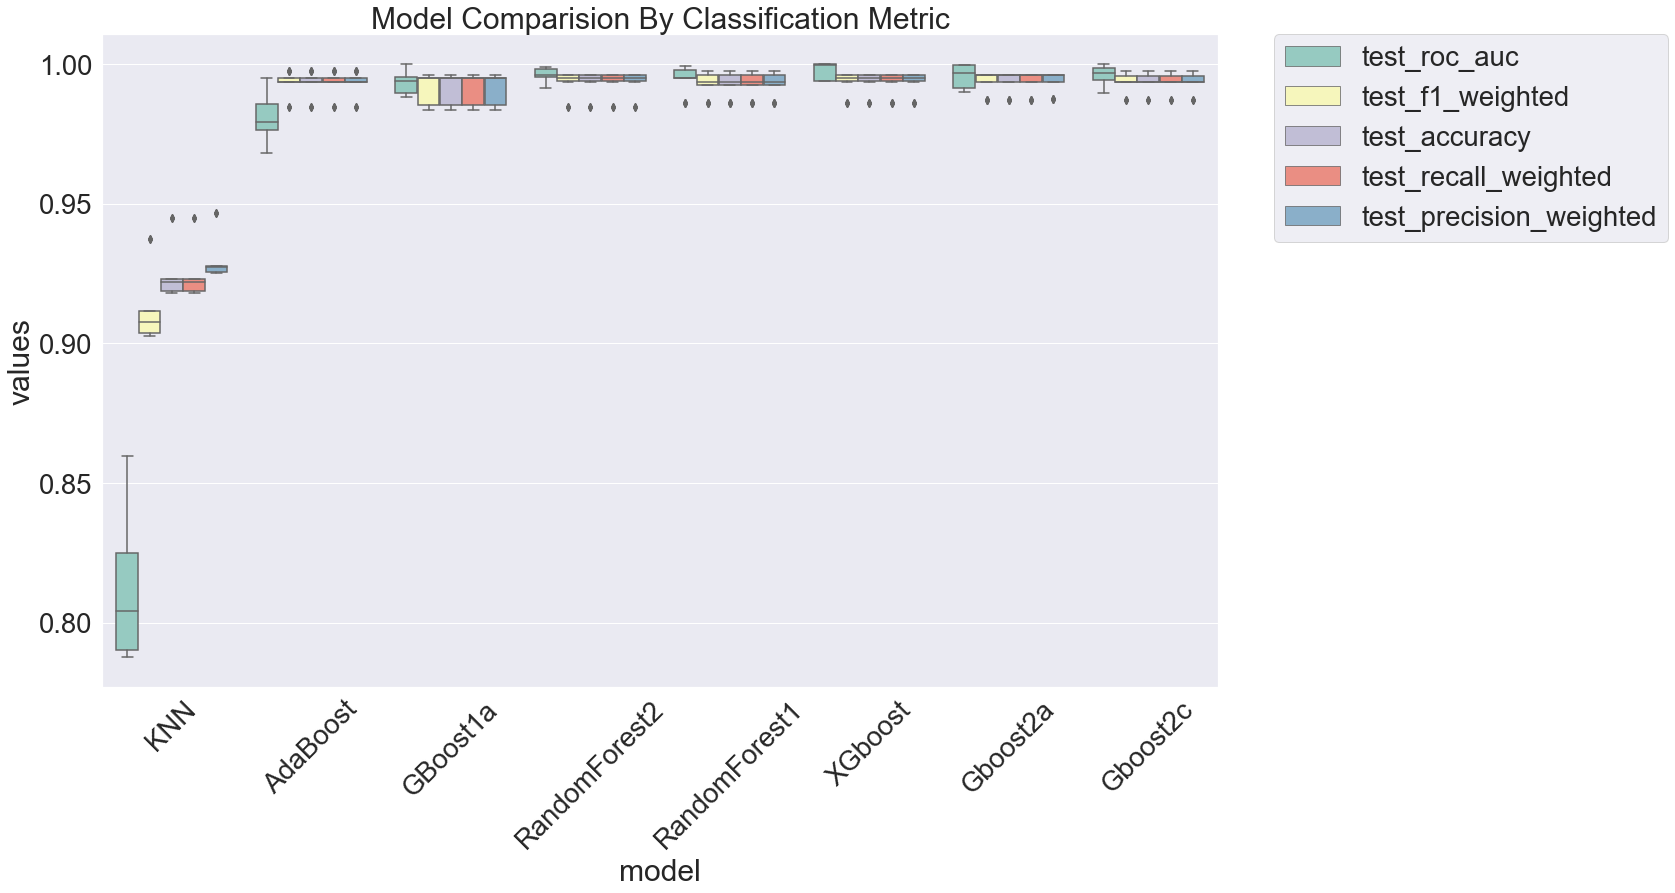

In [69]:
plot_results(scores_df)

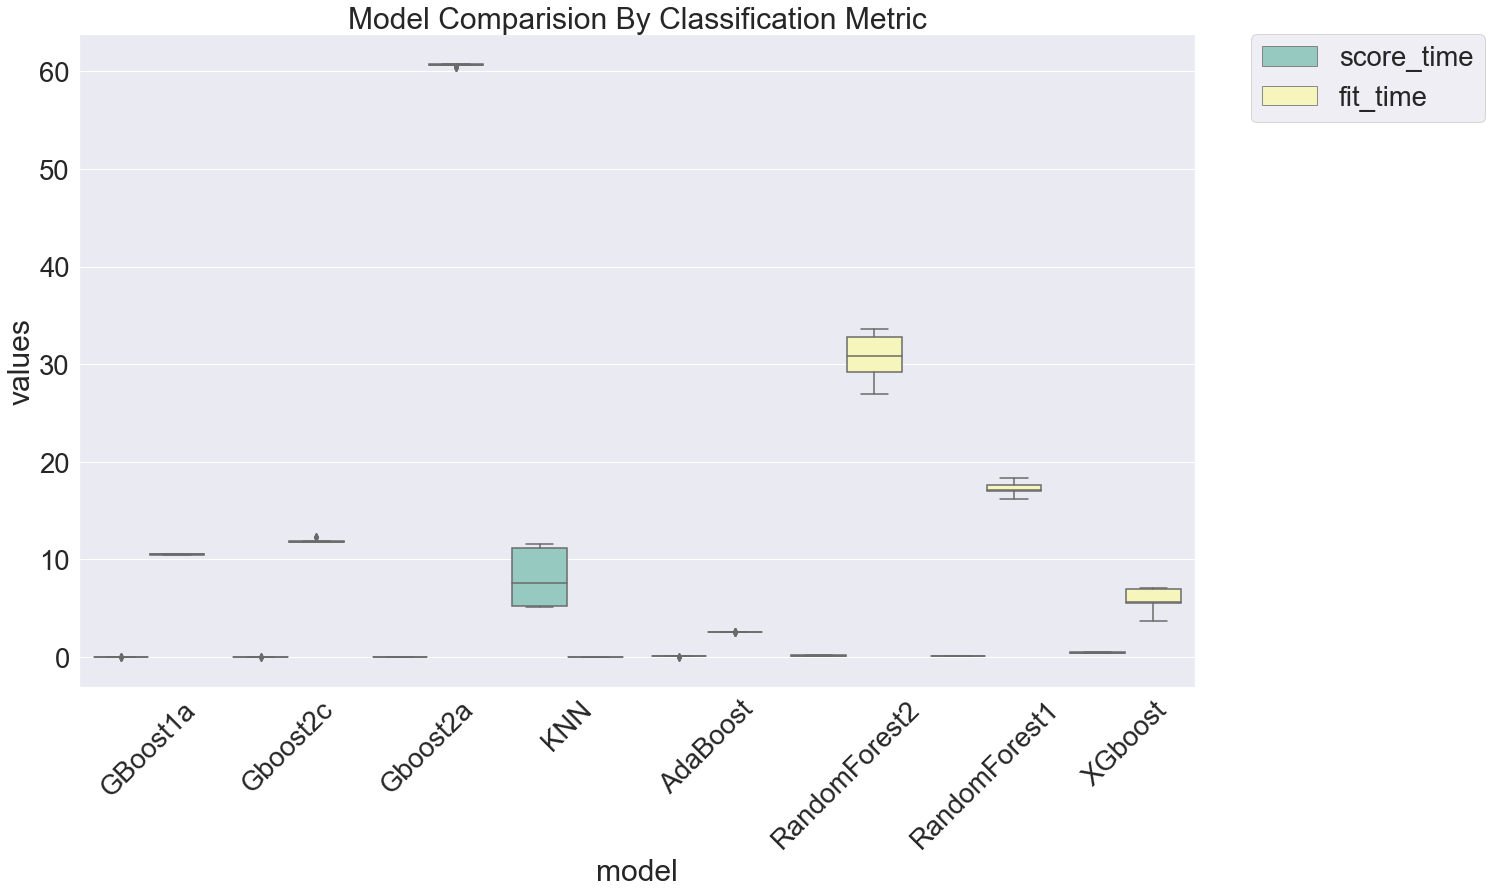

In [70]:
plot_results(times_df)

In [50]:
metrics = list(set(scores_df.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_roc_auc           test_f1_weighted            \
                       std      mean              std      mean   
model                                                             
AdaBoost          0.008615  0.981502         0.003812  0.993437   
GBoost1a          0.003720  0.993625         0.004976  0.991075   
Gboost2a          0.004306  0.995020         0.003656  0.993460   
Gboost2c          0.003229  0.995815         0.002934  0.993572   
KNN               0.023908  0.811797         0.010893  0.911115   
RandomForest1     0.005071  0.994279         0.004066  0.992418   
RandomForest2     0.002273  0.996079         0.003703  0.993672   
XGboost           0.002716  0.997745         0.003612  0.993624   

              test_recall_weighted           test_precision_weighted  \
                               std      mean                     std   
model                                                                  
AdaBoost                  0.003814  0.993462                0.003813   
GBoost1a                  0.004988  0.991068                0.004964   
Gboost2a                  0.003678  0.993462                0.003626   
Gboost2c                  0.002935  0.993590                0.002934   
KNN                       0.008570  0.924017                0.006995   
RandomForest1             0.004059  0.992436                0.004075   
RandomForest2             0.003702  0.993675                0.003706   
XGboost                   0.003602  0.993632                0.003624   

                        test_accuracy            
                   mean           std      mean  
model                                            
AdaBoost       0.993449      0.003814  0.993462  
GBoost1a       0.991089      0.004988  0.991068  
Gboost2a       0.993485      0.003678  0.993462  
Gboost2c       0.993576      0.002935  0.993590  
KNN            0.929405      0.008570  0.924017  
RandomForest1  0.992419      0.004059  0.992436  
RandomForest2  0.993685      0.003702  0.993675  
XGboost        0.993637      0.003602  0.993632

In [62]:
metrics = list(set(times_df.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

score_time            fit_time           
                     std      mean       std       mean
model                                                  
AdaBoost        0.005402  0.060401  0.021687   2.568925
GBoost1a        0.006356  0.003125  0.015343  10.512539
Gboost2a        0.007652  0.021345  0.136420  60.644620
Gboost2c        0.005400  0.013536  0.152838  11.878652
KNN             2.920714  7.988052  0.012060   0.028324
RandomForest1   0.000004  0.140596  0.748901  17.252338
RandomForest2   0.023351  0.159337  2.192236  30.812409
XGboost         0.041111  0.422316  1.062806   6.013116

---